# Analyzing NIH grant abstracts to predict total funds awarded

In this notebook we will attempt to predict how much funding a grant is awarded based on the grant abstract and the number of years a grant is funded. We will also identify funding/research trends over the years. The code to obtain these data and perform initial cleaning can be found [here](download-clean-data.ipynb).

In [50]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[Local functions](https://github.com/yuwie10/nih-awards/blob/master/nih_functions.py) for this project.

In [105]:
import nih_functions as nih
import importlib as imp
imp.reload(nih);

To specify the dtypes on import, let's first import a single row and examine the columns.

In [17]:
cols = pd.read_csv('for_analysis.csv', compression = 'gzip', nrows = 1)
cols

,application_id,activity,application_type,arra_funded,funding_mechanism,fy,nih_spending_cats,phr,project_start,project_end,project_terms,study_section,study_section_name,support_year,funds,pi_ids,num_pis
0,6258248,c06,1,NaN,NaN,2000,NaN,NaN,2000-09-22,NaN,NaN,strb,scientific and technical review board on biome...,1,1488000.0,1860776,1


In [28]:
dates = ['project_start', 'project_end']
numeric = ['funds', 'support_year', 'num_pis']

#get dtypes
dtypes = nih.get_dtypes(cols, numeric)

grants = pd.read_csv('for_analysis.csv', compression = 'gzip',
                    dtype = dtypes, parse_dates = dates)

There are many different types of grants, including institutional training grants and contracts. For this analysis, we are only interested in individual research grants (see [here](https://grants.nih.gov/grants/funding/funding_program.htm) for more details). Let's begin with R01 grants, which are the main research grants that fund academic labs. We can then extend this analysis to other types of grants such as R21s (smaller, exploratory grants), K99/R00s (grants for individuals to transition from postdoc to principal investigator) and pre- and post-doctoral grants.

In [34]:
r01s = grants.ix[grants['activity'] == 'r01']
r01s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517427 entries, 40104 to 1446253
Data columns (total 17 columns):
application_id        517427 non-null object
activity              517427 non-null object
application_type      517427 non-null object
arra_funded           250790 non-null object
funding_mechanism     250790 non-null object
fy                    517427 non-null object
nih_spending_cats     234269 non-null object
phr                   191126 non-null object
project_start         517420 non-null datetime64[ns]
project_end           100571 non-null datetime64[ns]
project_terms         498529 non-null object
study_section         516041 non-null object
study_section_name    515749 non-null object
support_year          517427 non-null float64
funds                 513853 non-null float64
pi_ids                517427 non-null object
num_pis               517427 non-null float64
dtypes: datetime64[ns](2), float64(3), object(12)
memory usage: 71.1+ MB


Most R01s do not have an abstract (public health relevance (phr) statement, also formerly known as the project narrative) associated with the submission. In fact, only grants from 2008 and later have a non-missing entry for phr. Prior to 2008 the NIH either did not ask for this field or the entries were not entered into the database. As we would like to analyze NIH grants based on text data, we will filter out grants without abstract entries. There is also a key words entry (project_terms) that, although not as rich as the text data in phr, may also be useful, especially if these key words can be compared with key words from grants with a listed abstract. We will save those observations with project_terms in a separate dataframe as well.

In [88]:
key_words = r01s.ix[r01s['project_terms'].notnull()]
phr = r01s.ix[r01s['phr'].notnull()]

Let's get a sense of how many years R01s (with an abstract) generally get funded.

In [82]:
phr['support_year'].value_counts()

1.0     39131
2.0     34053
3.0     27790
4.0     21503
5.0     14275
6.0      7614
7.0      6078
8.0      5203
9.0      4576
10.0     3902
11.0     3256
12.0     2799
13.0     2395
14.0     2070
15.0     1817
16.0     1537
17.0     1323
18.0     1180
19.0     1039
20.0      882
21.0      818
22.0      781
23.0      731
24.0      702
25.0      692
26.0      647
27.0      571
28.0      552
29.0      497
30.0      423
31.0      370
32.0      313
33.0      270
34.0      232
35.0      197
36.0      168
37.0      142
38.0      119
39.0       97
40.0       79
41.0       66
42.0       48
43.0       36
44.0       35
45.0       26
46.0       18
47.0       17
48.0       13
49.0       11
50.0        8
51.0        7
57.0        3
54.0        3
55.0        3
56.0        3
52.0        2
60.0        1
58.0        1
59.0        1
Name: support_year, dtype: int64

As expected, most R01s are funded for 5 or fewer years. The number of years is related to the type of application, descriptions of which we list below (information scraped in [this](scrape-grant-info.ipynb) notebook).

In [110]:
nih.view_col_info('app_types.csv', col_name = 'type')

,type,stage,description
0,1,New,Initial request for support of a project that has not yet been funded.
1,2,Renewal,"Initial request for additional funding for a period subsequent to that provided by a current award. Renewal applications compete for funding with all other peer reviewed applications and must be developed as fully as though the applicant is applying for the first time. (Previously referred to as “competing continuation.”) If your renewal and subsequent resubmission of renewal application are not funded, you must use the ""new"" application type to compete for additional funding and continuity with your previous award will not be retained."
2,3,Competing Revision,"Initial request for (or the award of) additional funds during a current project period to support new or additional activities that are not identified in the current award. This request reflects an expansion of the scope of the grant-approved activities. Competitive revisions require peer review. (Competing revision replaces the previous NIH term, ""competing supplement."") An administrative supplement is a request for (or the award of) additional funds during a current project period to provide for an increase in costs due to unforeseen circumstances. All additional costs must be within the scope of the peer reviewed and approved project."
3,4,Extension,Request for additional years of support beyond the years previously awarded. (Used only for select programs.)
4,5,Noncompeting Continuation,Request or award for a subsequent budget period within a previously approved project for which a recipient does not have to compete with other applications.
5,6,Change of Organization Status (Successor-in-Interest),"Process whereby the rights to and obligations under an NIH grant(s) are acquired incidental to the transfer of all of the assets of the grantee or the transfer of that part of the assets involved in the performance of the grant(s). May result from legislative or other legal action, such as a merger or other corporate change."
6,7,Change of Grantee or Training Institution,Transfer of the legal and administrative responsibility for a grant-supported project or activity from one legal entity to another before the completion date of the approved project period (competitive segment).
7,8,Change of Institute or Center,Change of awarding NIH institute or center for the noncompeting continuation (Type 5).
8,9,Change of Institute or Center,Change of awarding NIH institute or center for the renewal (Type 2).


For our purposes we can merge some of these application types to make analysis simpler, i.e., types 6-9 simply refer to Institutional transfers.

Let's first look at how many grants fell into each application type.

In [115]:
phr['application_type'].value_counts()

5    115357
1     38084
2     14578
3      9687
4      8261
7      4223
6       634
9       262
8        40
Name: application_type, dtype: int64

In [116]:
nih.view_col_info('app_types.csv', [6, 7], col_name = 'type')

,type,stage,description
5,6,Change of Organization Status (Successor-in-Interest),"Process whereby the rights to and obligations under an NIH grant(s) are acquired incidental to the transfer of all of the assets of the grantee or the transfer of that part of the assets involved in the performance of the grant(s). May result from legislative or other legal action, such as a merger or other corporate change."
6,7,Change of Grantee or Training Institution,Transfer of the legal and administrative responsibility for a grant-supported project or activity from one legal entity to another before the completion date of the approved project period (competitive segment).


Let's merge different application types into single categories in the following way:

* Merge 5 and 8
* Merge 2 and 6, 7, 9

In [109]:
phr.describe()

,support_year,funds,num_pis
count,191126.000000,1.901460e+05,191126.000000
mean,5.556905,3.448723e+05,1.344077
std,6.381470,1.924590e+05,0.702543
min,1.000000,0.000000e+00,1.000000
25%,2.000000,2.513270e+05,1.000000
50%,3.000000,3.328415e+05,1.000000
75%,6.000000,3.993470e+05,2.000000
max,60.000000,8.046691e+06,9.000000


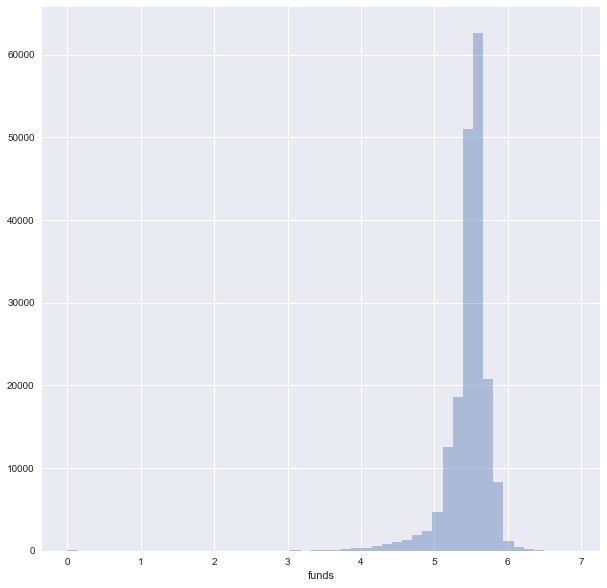

In [85]:
#to_plot = r01s['funds'].dropna()
to_plot = phr.ix[phr['funds'] != 0]
to_plot = np.log10(to_plot['funds'].dropna())

fig, _ = plt.subplots()
fig.set_size_inches(10, 10)
_ = sns.distplot(to_plot, kde = False)

In [86]:
phr['fy'].value_counts()

2016    30695
2015    29676
2013    29456
2014    29350
2012    26729
2011    20041
2010    15658
2009     9014
2008      507
Name: fy, dtype: int64